# Rozpoznawanie guza mózgu przy pomocy głębokich sieci neuronowych

Należy odpowiednio umieścić katalogi i pliki z danymi w Google Drive. Struktura plików powinna pasować do poniższego wyniku wywołania polecenia `tree`.

Pliki należy pobrać z [tego linku w Google Drive](https://drive.google.com/file/d/1qomYopqMzOZmrcimf3x0o_NXt3OQPfoc/view?usp=sharing). Dostęp do pliku jest ograniczony i należy zażądać do niego dostępu.

```
Colab Notebooks/
└── Brain Tumor Detection/
    ├── data/
    │   ├── masks/
    │   │   ├── Y1.jpg
    │   │   ├── Y2.jpg
    │   │   └── ...
    │   ├── yes/
    │   │   ├── Y1.jpg
    │   │   ├── Y2.jpg
    │   │   └── ...
    │   └── no/
    │       ├── 1 no.jpeg
    │       ├── 2 no.jpeg
    │       └── ...
    ├── Brain-Tumor-Detection-01.h5
    └── Brain-Tumor-Segmentation-01.h5
```

Montowanie katalogu Google Drive.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Definicja podstawowych katalogów w Google Drive.

In [ ]:
positives_path = '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/data/yes'
negatives_path = '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/data/no'
masks_path     = '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/data/masks'


detection_modelfile    = '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/Brain-Tumor-Detection-01.h5'
segmentation_modelfile = '/content/drive/MyDrive/Colab Notebooks/Brain Tumor Detection/Brain-Tumor-Segmentation-01.h5'

Ustawienie ziarna generatora liczb pseudolosowych, dla reprodukowalnych wyników.

In [ ]:
import numpy as np

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

np.random.seed(2021)

## Przygotowanie zbioru danych

In [ ]:
import os

positives = os.listdir(positives_path)
negatives = os.listdir(negatives_path)

positives = [f'{positives_path}/{file}' for file in positives]
negatives = [f'{negatives_path}/{file}' for file in negatives]

len(positives), len(negatives)

(128, 98)

Pobrane pliki zostają połączone, z zapamiętaniem, który z nich stanowi wynik pozytywny (klasa `1`) oraz który z nich stanowi wynik negatywny (klasa `0`).

Zbiór danych zostaje losowo pomięszany.

In [ ]:
from sklearn.utils import shuffle

files = []
labels = []

for file in positives:
    files.append(file)
    labels.append(1)

for file in negatives:
    files.append(file)
    labels.append(0)

files, labels = shuffle(files, labels)

## Podział na dane trenujące i dane testowe


In [ ]:
from sklearn.model_selection import train_test_split

files_train, files_test, labels_train, labels_test = train_test_split(files, labels, test_size=0.2)

len(files_train), len(files_test), len(labels_train), len(labels_test)

(180, 46, 180, 46)

Ze ścieżek do plików obrazy zostają wczytane, przeskalowane do rozmiarów `(126, 126)`.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def read_scale_images(paths, width=IMAGE_WIDTH, height=IMAGE_HEIGHT):
    images = []

    for file in paths:
        image = Image.open(file)
        image = image.resize((width, height), Image.ANTIALIAS)
        image = np.array(image)

        if len(image.shape) == 3:
            image = image[:, :, 0]

        images.append(image)

    images = np.array(images)
    return images

Wczytanie danych graficznych z Google Drive.

**[Uwaga]** To zadanie może potrwać trochę dłuzej.

In [ ]:
x_train = read_scale_images(files_train)
x_test = read_scale_images(files_test)

y_train = np.array(labels_train)
y_test = np.array(labels_test)

Zmieniany jest wymiar danych do pracy z sieciami konwoluicyjnymi.

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

## Model głębokiej sieci neuronowej konwolucyjnej

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten

def model_tumor_detection():
    model = Sequential()
    model.add(Conv2D(50, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(128, 128, 1)))
    model.add(Conv2D(75, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(125, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(250, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
model = model_tumor_detection()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 50)      500       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 75)      33825     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 75)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64, 64, 75)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 125)       84500     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 125)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 125)      

### Trenowanie sieci neuronowej

Model najlepszy, wg kryteriów `val_accuracy` zostanie zapisany do pliku `Brain-Tumor-Detection-01.h5`.

Można pominąć krok trenowania sieci i wczytać już wcześniej przygotowany model. Jest to możliwe w kolejnych blokach kodu.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

save = True

callbacks = []

if save:
    checkpoint = ModelCheckpoint(detection_modelfile, monitor='val_accuracy', save_best_only=True)
    callbacks.append(checkpoint)

model.fit(x_train, y_train, batch_size=8, epochs=50, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
18/18 [==============================] - 3s 105ms/step - loss: 237.3772 - accuracy: 0.4998 - val_loss: 0.6609 - val_accuracy: 0.5833
Epoch 2/50
18/18 [==============================] - 2s 88ms/step - loss: 0.5778 - accuracy: 0.7085 - val_loss: 0.6174 - val_accuracy: 0.6944
Epoch 3/50
18/18 [==============================] - 2s 87ms/step - loss: 0.5433 - accuracy: 0.7503 - val_loss: 0.5538 - val_accuracy: 0.6667
Epoch 4/50
18/18 [==============================] - 2s 86ms/step - loss: 0.4306 - accuracy: 0.7605 - val_loss: 0.6120 - val_accuracy: 0.6389
Epoch 5/50
18/18 [==============================] - 2s 86ms/step - loss: 0.4219 - accuracy: 0.7743 - val_loss: 0.5643 - val_accuracy: 0.6667
Epoch 6/50
18/18 [==============================] - 2s 87ms/step - loss: 0.3758 - accuracy: 0.8250 - val_loss: 0.5416 - val_accuracy: 0.6389
Epoch 7/50
18/18 [==============================] - 2s 86ms/step - loss: 0.4040 - accuracy: 0.7939 - val_loss: 0.5699 - val_accuracy: 0.7222
Epoch 8/50

Wykresy przedstawiający zmianę wartości funkcji straty oraz zmianę skuteczności, zależnie od epoki trenowania.

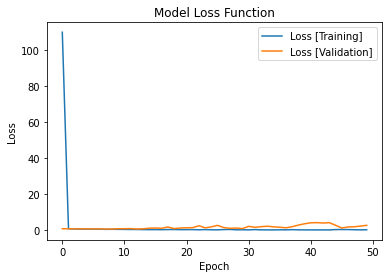

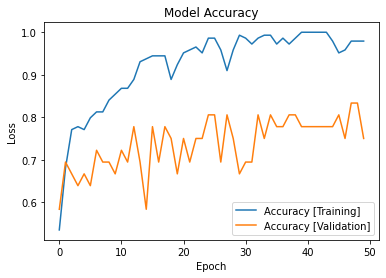

In [ ]:
history = model.history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss Function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss [Training]', 'Loss [Validation]'], loc='upper right')

plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy [Training]', 'Accuracy [Validation]'], loc='lower right')

plt.show()

Test skuteczności na modelu sieci neuronowej pochodzącej z ostatniej epoki trenowania.

In [ ]:
model.evaluate(x_test, y_test, batch_size=8)

6/6 [==============================] - 0s 22ms/step - loss: 3.2611 - accuracy: 0.7826


[3.2610976696014404, 0.782608687877655]

### Wczytanie modelu sieci neuronowej

Wczytanie modelu. Model pochodzi z najlepszej epoki trenowania sieci, wg kryteriów `val_accuracy`.

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(detection_modelfile)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Test skuteczności modelu sieci neuronowej

Test skuteczności na zapisanym modelu sieci neuronowej, najlepszym, eg kryteriów `val_accuracy`.

In [ ]:
model.evaluate(x_test, y_test, batch_size=8)

6/6 [==============================] - 0s 20ms/step - loss: 3.8129 - accuracy: 0.7142


[2.926476240158081, 0.739130437374115]

Skuteczność wytrenowanej sieci do rozpoznawania czy obraz przedstawia nowotwór wynosi `78%`.

## Segmentacja obrazu

Kolejnym krokiem jest wskazanie miejsca, gdzie guz występuje na obrazie. Czynność ta jest bardziej skomplikowana i wymaga zastosowania techniki zwanej segmentacją obrazów.

Do tego, wykorzystuje się segmentację obrazów. Segmentacja różni się od rozpoznawania obrazów. Algorytmy rozpoznawania obrazów, kreślą prostokątne obramowanie wokół obszaru, na którym obiekt danej klasy występuje. Jedyne co takie algorytmy wskazują, to położenie obiektu na obrazie, pomijając skomplikowaną strukturę, jaką ten obiekt może przyjmować. W przypadku rozpoznawania rozmiaru guza nowotworowego, znacznie bardziej użytwczne jest wskazanie obszaru o dowolnym kształcie, na którym nowotwór występuje. Dzięki temu znane jest nie tylko położenie danego obiektu, ale również jego struktura.

<div align="center">
    <img src="https://i.stack.imgur.com/sXrwS.jpg" />
</div>

Powyższy obrazek prezentuje omawiane różnice.

W celu nauczenia sieci neuronowej rozpoznawania takich kształtów, należy odpowiednio przygotować zbiór danych. Dla każdego guza, konieczne jest przygotowanie obrazu, który zawierałby nakreślony wyłącznie obszar, na którym nowotwór się znajduje. Wszystkie piksele, na których guz się nie znajduje, przyjmują wartość `0`, a piksele, które odpowiadają pikselom góza, przyjmują wartość `1`. Operacja mnożenia tablicowego (nie mylić z macierzowym) zwróci wycinek oryginalnego obrazu, na którym znajduje się guz. Taki obraz nazywany jest maską.


<div align="center">
    <img src="https://i.imgur.com/dckwGbX.png" />
</div>

### Wczytanie mask dla zbioru danych

Do wytrenowania sieci wykorzystywane są tylko te obrazy, na których rzeczywiście występuje góz nowotworowy (klasa `1`). Do tego, wykorzystujemy tylko i wyłącznie ten sam zbiór danych trenujących jak w poprzednim zagadnieniu.

In [ ]:
segm_files_train = []
mask_files_train = []

for i in range(len(files_train)):
    if labels_train[i] == 1:
        segm_files_train.append(files_train[i])
        mask_file = files_train[i].split('/')[-1]
        mask_file = f'{masks_path}/{mask_file}'
        mask_files_train.append(mask_file)

In [ ]:
segm_files_test = []
mask_files_test = []

for i in range(len(files_test)):
    if labels_test[i] == 1:
        segm_files_test.append(files_test[i])
        mask_file = files_test[i].split('/')[-1]
        mask_file = f'{masks_path}/{mask_file}'
        mask_files_test.append(mask_file)

W celu pozbycia się szumów z procesu obróbki graficznej masek, wszystkie wartości, które przypadkiem byłyby różne niż `0` (kolor czarny) i `255` (kolor biały), zostają ustawione na `255`. 

In [ ]:
def normalize_masks(mask_images):

    result = []

    def normalize_mask(mask_image):
        mask_image = np.copy(image)
        for i in range(mask_image.shape[0]):
            for j in range(mask_image.shape[1]):
                mask_image[i, j] = 0 if mask_image[i, j] == 0 else 255
        return mask_image

    for image in mask_images:
        image = normalize_mask(image)
        result.append(image)

    result = np.array(result)
    return result

Dla uproszczenia samego kodu, pliki są wczytywane ponownie.

**[Uwaga]** To zadanie może potrwać trochę dłuzej.

In [ ]:
segm_images_train = read_scale_images(segm_files_train)
segm_masks_train = read_scale_images(mask_files_train)

segm_masks_train = normalize_masks(segm_masks_train)

In [ ]:
segm_images_test = read_scale_images(segm_files_test)
segm_masks_test = read_scale_images(mask_files_test)

segm_masks_test = normalize_masks(segm_masks_test)

Opcjonalnie można wyswietlić obrazy oraz ich maski.

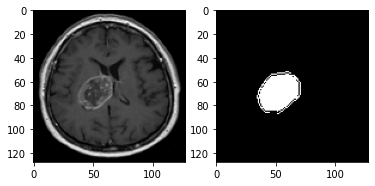

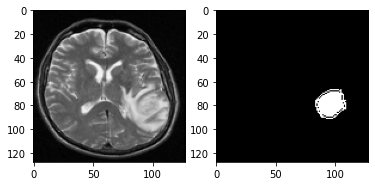

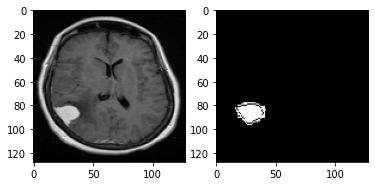

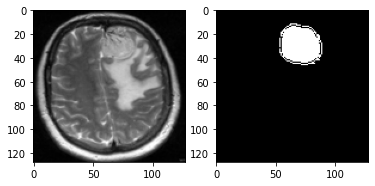

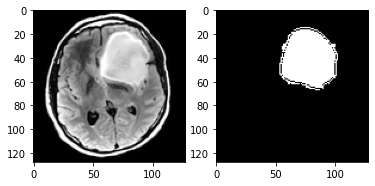

In [ ]:
for i in range(min(len(segm_images_train), 5)):
    f = plt.figure()
    f.add_subplot(1, 2, 1)
    plt.imshow(segm_images_train[i], cmap='gray')
    f.add_subplot(1, 2, 2)
    plt.imshow(segm_masks_train[i], cmap='gray')

In [ ]:
x_train_segm = np.zeros((len(segm_images_train), IMAGE_WIDTH, IMAGE_HEIGHT, 1), dtype=np.uint8)
y_train_segm = np.zeros((len(segm_masks_train), IMAGE_WIDTH, IMAGE_HEIGHT, 1), dtype=np.bool)

for i in range(len(segm_images_train)):
    x_train_segm[i] = segm_images_train[i].reshape((IMAGE_WIDTH, IMAGE_HEIGHT, 1))
    y_train_segm[i] = segm_masks_train[i].reshape((IMAGE_WIDTH, IMAGE_HEIGHT, 1))

In [ ]:
x_test_segm = np.zeros((len(segm_images_test), IMAGE_WIDTH, IMAGE_HEIGHT, 1), dtype=np.uint8)
y_test_segm = np.zeros((len(segm_masks_test), IMAGE_WIDTH, IMAGE_HEIGHT, 1), dtype=np.bool)

for i in range(len(segm_images_test)):
    x_test_segm[i] = segm_images_test[i].reshape((IMAGE_WIDTH, IMAGE_HEIGHT, 1))
    y_test_segm[i] = segm_masks_test[i].reshape((IMAGE_WIDTH, IMAGE_HEIGHT, 1))

### Model sieci neuronowej U-Net CNN

Wykorzystany zostanie gotowy model sieci neuronowej U-Net CNN. Sieć ta została zaprojektowana specjalnie z myślą o zastosowaniu w diagnostyce medycznej. Kod źródłowy modelu w technologii Tensorflow został zaczerpnięty z serwisu [Kaggle](https://www.kaggle.com/naghmehsh/image-segmentation-for-detecting-brain-tumor#Step-3:-Building-U-net-CNN-Model).

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import  concatenate, Conv2D, Conv2DTranspose, Dropout, Input, Lambda, MaxPooling2D

def make_unet_cnn():
    inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 1))

    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    # Note our output is effectively a mask of 128 x 128 
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
unet_cnn = make_unet_cnn()
unet_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

unet_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 128, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 128, 128, 16) 0           conv2d_9[0][0]                   
______________________________________________________________________________________________

### Trenowanie sieci neuronowej

Krok ten można pominąć i wczytać sieć neuronową już przygotowaną.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

save = True

callbacks = []

if save:
    checkpoint = ModelCheckpoint(segmentation_modelfile, monitor='val_accuracy', save_best_only=True)
    callbacks.append(checkpoint)

unet_cnn.fit(x_train_segm, y_train_segm, batch_size=8, validation_split=0.2, epochs=50, callbacks=callbacks)

Epoch 1/50
10/10 [==============================] - 6s 287ms/step - loss: 0.4100 - accuracy: 0.8878 - val_loss: 0.2353 - val_accuracy: 0.9408
Epoch 2/50
10/10 [==============================] - 1s 75ms/step - loss: 0.2394 - accuracy: 0.9305 - val_loss: 0.1994 - val_accuracy: 0.9408
Epoch 3/50
10/10 [==============================] - 1s 75ms/step - loss: 0.2014 - accuracy: 0.9413 - val_loss: 0.1915 - val_accuracy: 0.9381
Epoch 4/50
10/10 [==============================] - 1s 76ms/step - loss: 0.1892 - accuracy: 0.9374 - val_loss: 0.1917 - val_accuracy: 0.9288
Epoch 5/50
10/10 [==============================] - 1s 75ms/step - loss: 0.1885 - accuracy: 0.9358 - val_loss: 0.1821 - val_accuracy: 0.9383
Epoch 6/50
10/10 [==============================] - 1s 75ms/step - loss: 0.1807 - accuracy: 0.9377 - val_loss: 0.1646 - val_accuracy: 0.9389
Epoch 7/50
10/10 [==============================] - 1s 75ms/step - loss: 0.1776 - accuracy: 0.9377 - val_loss: 0.1700 - val_accuracy: 0.9347
Epoch 8/50
1

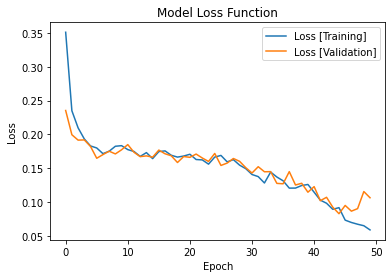

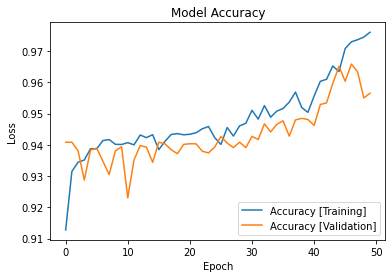

In [ ]:
history = unet_cnn.history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss Function')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss [Training]', 'Loss [Validation]'], loc='upper right')

plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy [Training]', 'Accuracy [Validation]'], loc='lower right')

plt.show()

In [ ]:
unet_cnn.evaluate(x_test_segm, y_test_segm, batch_size=8)

4/4 [==============================] - 1s 163ms/step - loss: 0.1303 - accuracy: 0.9572


[0.13026271760463715, 0.9571533203125]

### Wczytanie modelu sieci neuronowej

Wczytanie modelu. Model pochodzi z najlepszej epoki trenowania sieci, wg kryteriów `val_accuracy`.

In [ ]:
from tensorflow.keras.models import load_model

unet_cnn = load_model(segmentation_modelfile)
unet_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Test skuteczności modelu sieci neuronowej

Test skuteczności na zapisanym modelu sieci neuronowej, najlepszym, eg kryteriów `val_accuracy`.

In [ ]:
unet_cnn.evaluate(x_test_segm, y_test_segm, batch_size=8)

4/4 [==============================] - 1s 23ms/step - loss: 0.1141 - accuracy: 0.9699


[0.14746399223804474, 0.9629221558570862]

### Prezentacja wyników segmentacji

Sieć neuronowa zwraca macierz prawdopodobieństw, że dany punkt reprezentuje obszar objęty zmianą nowotworową. Gdy prawdopodobieństwo to jest większe bądź równe do `0.5`, punkt jest uznany za pozytywne trafienie.

Prezentowane są trzy obrazy - oryginalny obraz guza nowotworowego, będący daną wejściową dla sieci, oryginalna maska, będąca spodziewanym wynikiem oraz maska otrzymana z sieci neuronowej. 

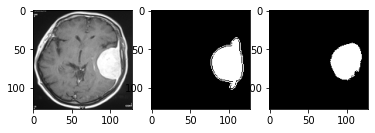

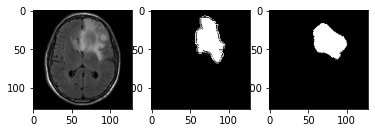

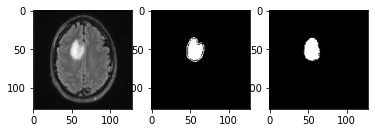

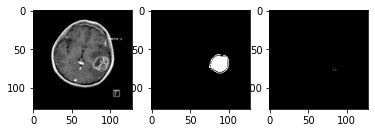

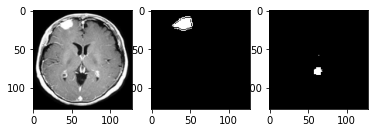

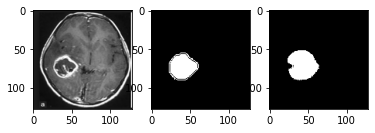

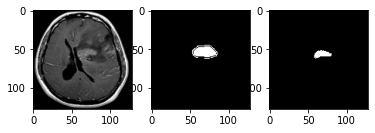

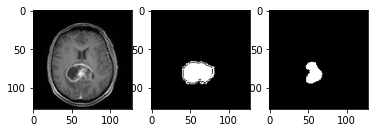

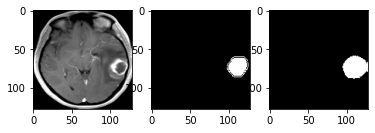

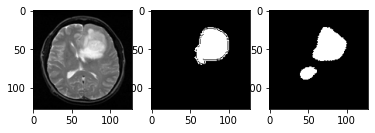

In [ ]:
result = unet_cnn(x_test_segm)
result = result.numpy()
result = (result >= 0.5)

for i in range(min(len(result), 10)):
    f = plt.figure()
    f.add_subplot(1, 3, 1)
    plt.imshow(x_test_segm[i].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap='gray')
    f.add_subplot(1, 3, 2)
    plt.imshow(y_test_segm[i].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap='gray')
    f.add_subplot(1, 3, 3)
    plt.imshow(result[i].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap='gray')